Importing Libraries

In [13]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
import uuid

Creating the path of the files

In [14]:

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

Creating the directories

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

Link to images of pictures: <br>
http://vis-www.cs.umass.edu/lfw/ <br>
Download the "All images as gzipped tar file"

Untar Labelled Faces in the Wild Dataset

In [ ]:
!tar -xf lfw.tgz

Placing the images in the folder with negative examples <br>
(pictures of people that isn't me)

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)
#After this you can delete the ltw folder

Establish a connection to the webcam and adding photos to anchor and positive directories <br>
(anchor images will be compared against positive and negative images)

In [70]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    
    # Cut down frame to 250x250px
    frame = frame[100:100+250,200:200+250, :]
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Collect anchors with a
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives with p
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
        
    # Breaking with q
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
#Collect at least 200 in anchor (a) and in positive (p)

Data Augmentation

In [71]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        data.append(img)
    
    return data

In [72]:
#Augmenting the ANCHOR photos
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [73]:
#Augmenting the POSITIVE photos
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [17]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(4320)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(4320)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(4320)

Preprocessign function: <br>
(pasarlo a (100,100) y comprimirlo de 0 a 1)

In [15]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

zipping and concatanating the positives and negatives

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

Build dataloader pipeline:

In [20]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=8000)

<h3>I was going to divide between train and test, but decided to use all the data to train and test only in real time </h3><br>
    all that is commented is because of this

In [25]:
## Training partition
#train_data = data.take(round(len(data)*.8))
#train_data = train_data.batch(16)
#train_data = train_data.prefetch(8)

## Testing partition
#test_data = data.skip(round(len(data)*.8))
#test_data = test_data.take(round(len(data)*.2))
#test_data = test_data.batch(16)
#test_data = test_data.prefetch(8)


In [91]:
data = data.batch(16)
data = data.prefetch(8)

CNN Function to embedding:

In [79]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [80]:
embedding = make_embedding()

In [12]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

Siamese L1 Distance class

In [2]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [3]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [83]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [6]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [85]:
#test_batch = train_data.as_numpy_iterator()

In [86]:
#batch_1 = test_batch.next()

In [93]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [88]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

Creating the training function and training the model

In [94]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

Training

In [95]:
EPOCHS = 25
train(data, EPOCHS)


 Epoch 1/25
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
540/540 [==============================] - 197s 329ms/step
0.041734003 0.9560185 0.98969567

 Epoch 2/25
540/540 [==============================] - 217s 402ms/step
0.0007193892 0.9886574 0.9946437

 Epoch 3/25
540/540 [==============================] - 215s 398ms/step
0.0007375334 0.99467593 0.9967525

 Epoch 4/25
540/540 [==============================] - 209s 387ms/step
0.03839586 0.99560183 0.9965246

 Epoch 5/25
540/540 [==============================] - 209s 388ms/step
0.042874623 0.9988426 0.9979186

 Epoch 6/25
540/540 [==============================] - 207s 383ms/step
0.0002382559 0.99837965 0.9967645

 Epoch 7/25
540/540 [==============================] - 206s 382ms/step
0.0062641576 0.9988426 0.99838036

 Epoch 8/25
540/540 [==============================] - 206s 381ms/step
0.00042893132 0.99837965 0.99907345

 Epoch 9/25
540/540 [==============================] - 205s 380ms/step
0.91030

In [18]:
#test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [19]:
#y_hat = siamese_model.predict([test_input, test_val])

In [25]:
#[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]

In [26]:
#y_true

array([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [20]:
# # Creating a metric object 
# m = Recall()

# # Calculating the recall value 
# m.update_state(y_true, y_hat)

# # Return Recall Result
# m.result().numpy()

1.0

In [21]:
# # Creating a metric object 
# m = Precision()

# # Calculating the recall value 
# m.update_state(y_true, y_hat)

# # Return Recall Result
# m.result().numpy()

1.0

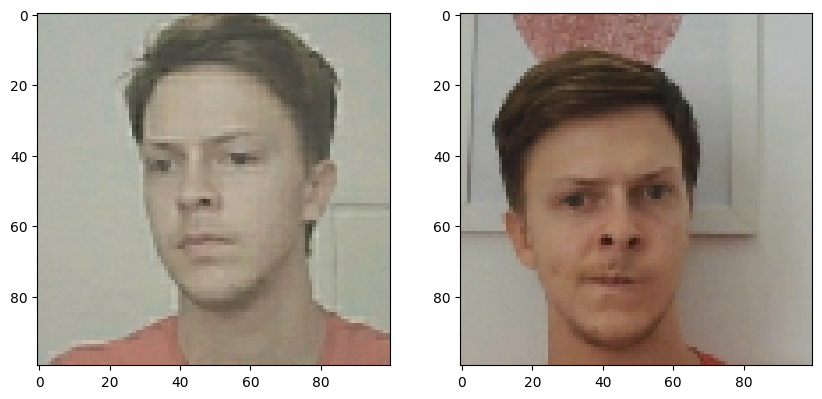

In [22]:
# # Set plot size 
# plt.figure(figsize=(10,8))

# # Set first subplot
# plt.subplot(1,2,1)
# plt.imshow(test_input[4])

# # Set second subplot
# plt.subplot(1,2,2)
# plt.imshow(test_val[4])

# # Renders cleanly
# plt.show()

In [96]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [5]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [31]:
VERIF_PATH = os.path.join('application_data', 'verification_images')
INPUT_PATH = os.path.join('application_data', 'input_image')

os.makedirs(VERIF_PATH)
os.makedirs(INPUT_PATH)

#Place around 50 photos from the positive folder to the 'verification_images'

In [8]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [21]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[100:100+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
False
False
True
True
True
True
True
False
False
True


In [30]:
#to see and change the detection_threshold, higher means that is less likely to return false negatives.(you can change it in the previous cell)
np.sum(np.squeeze(results) > 0.7)

50

In [52]:
#verification_threshold
39/50

0.78